In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from dateutil.parser import parse
from itertools import chain
import operator
import sys
from fbprophet import Prophet
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from fbprophet import Prophet
from pandas.tseries.offsets import *
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
df_train = pd.read_csv("resources/train.csv")
df_test = pd.read_csv("resources/test.csv")

In [3]:
#Merge Train and Test into one dataframe
df_train_test = {'train': df_train, 'test': df_test}
df_result = pd.concat(df_train_test)

In [4]:
#df_result[df_result.Stock == 363].nsmallest(1000,['Stock','Day'])
df_result.head()

Day  Index  Market  Stock  Weight        x0        x1        x2  \
test 0   13      0       1    363     NaN  0.000842  0.436594  0.477848   
     1   13      1       1   1223     NaN  0.020800  0.636143  0.670798   
     2   13      2       1   1372     NaN  0.068580  0.478891  0.481816   
     3   13      3       1   1942     NaN  0.011986  0.463201  0.294900   
     4   13      4       1   2712     NaN  0.000164  0.549980  0.352332   

                 x3A           x3B           x3C           x3D           x3E  \
test 0  1.535381e-06  4.353950e-06  7.718616e-06  1.632886e-05  3.267851e-05   
     1  5.204133e-06  9.546012e-06  1.575258e-05  2.804666e-05  1.082500e-05   
     2  5.433730e-08  1.733539e-07  3.866963e-07  8.520664e-07  2.103176e-06   
     3  1.103215e-08  3.555558e-08  7.280376e-08  1.364231e-07  3.155050e-07   
     4  4.494670e-07  8.503405e-07  1.222847e-06  1.901114e-06  4.048304e-06   

              x4            x5          x6   y  
test 0  0.001661  9.724611e-07  112.968475 NaN  
     1  0.002104  2.146299e-05  100.000000 NaN  
     2  0.000222  3.085296e-08  188.335508 NaN  
     3  0.000141  1.678216e-08  212.123913 NaN  
     4  0.001235  4.595200e-07  124.024977 NaN

In [5]:
#Create a fitctitious start date
start_date ='2015-01-02'
date_range=pd.date_range(start_date, '2018-03-05', freq=BDay())

In [6]:
date_range = pd.DataFrame(date_range)
#date_range
#x= date_range.iloc[30,[0]]
#print(x)

In [7]:
date_range.tail()

,0
822,2018-02-27
823,2018-02-28
824,2018-03-01
825,2018-03-02
826,2018-03-05


In [8]:
def days_to_date(Day, Stock):
    ## print("Currently processing Stock: "+str(Stock)+" For Day:"+str(Day))
    try:
        Day_int = int(Day)
        return pd.to_datetime(date_range.iloc[Day_int,[0]])
    except:
        return pd.to_datetime('1900-01-01')

In [9]:
df_result.head()

Day  Index  Market  Stock  Weight        x0        x1        x2  \
test 0   13      0       1    363     NaN  0.000842  0.436594  0.477848   
     1   13      1       1   1223     NaN  0.020800  0.636143  0.670798   
     2   13      2       1   1372     NaN  0.068580  0.478891  0.481816   
     3   13      3       1   1942     NaN  0.011986  0.463201  0.294900   
     4   13      4       1   2712     NaN  0.000164  0.549980  0.352332   

                 x3A           x3B           x3C           x3D           x3E  \
test 0  1.535381e-06  4.353950e-06  7.718616e-06  1.632886e-05  3.267851e-05   
     1  5.204133e-06  9.546012e-06  1.575258e-05  2.804666e-05  1.082500e-05   
     2  5.433730e-08  1.733539e-07  3.866963e-07  8.520664e-07  2.103176e-06   
     3  1.103215e-08  3.555558e-08  7.280376e-08  1.364231e-07  3.155050e-07   
     4  4.494670e-07  8.503405e-07  1.222847e-06  1.901114e-06  4.048304e-06   

              x4            x5          x6   y  
test 0  0.001661  9.724611e-07  112.968475 NaN  
     1  0.002104  2.146299e-05  100.000000 NaN  
     2  0.000222  3.085296e-08  188.335508 NaN  
     3  0.000141  1.678216e-08  212.123913 NaN  
     4  0.001235  4.595200e-07  124.024977 NaN

In [ ]:
#Now Assign a Date for each day of the combined dataset.
#df['cons_score'] = df.apply(lambda row: analyze_text(row['cons'],row['name'])[0], axis=1)
df_result['FB_Date'] = df_result.apply(lambda row: days_to_date(row['Day'],row['Stock']), axis=1)

In [ ]:
df_result.head()
df_result.to_csv("output/df_result_fb1.csv")
#df_result.loc[ (df_result.Market == 1) & (df_result.Stock == 1223)].nsmallest(1000,['Stock','Day'])

In [ ]:
#Function to make repeated calls to Prophet for future values of all X values
#Open	High	Low	Close	Volume (BTC)	Volume (Currency)	Weighted Price
def run_fbp(reg_data,field_str,look_ahead):
    reg_data['y'] = np.log(reg_data[field_str])
    reg_data['ds'] = reg_data.index
    fb_reg_data = reg_data.loc[:,['ds','y']]
    fb_reg_data = fb_reg_data.reset_index(drop=True)
    fb_reg_data.dropna(inplace=True)
    m = Prophet()
    m.fit(fb_reg_data)
    future = m.make_future_dataframe(periods=look_ahead)
    forecast = m.predict(future)
    predicted  = forecast[['yhat', 'yhat_lower', 'yhat_upper']].applymap(np.exp)
    return predicted

In [ ]:
#Next Step would be for each stock model the prediction using 
#df_stock_data = df_train.loc[ (df_train.Market == 1) & (df_train.Stock == 1
Stock_table = df_result.groupby(['Market','Stock'])


In [ ]:
Stock_table.head()

In [ ]:
def run_fb(row):
    Market = row['Market']
    Stock = row['Stock']
    print("Runing for Market"+str(Market)+ " And Stock:"+str(Stock))
    return "Yes"

In [ ]:
#In [54]: df['Value'] = df.apply(my_test2, axis=1)
Stock_table['Evaluated'] = Stock_table.apply(run_fb, axis=1)

In [ ]:
Stock_table.loc[:,['Market','Stock','Day','Date']]

In [ ]:
#explore the data..
sns.distplot(df_train['y'])

In [ ]:
###### For a single market and stock what is the distribution over time ?
#df.loc[(df.Gender != 'Female') & ( df.Gender != 'Male') ]['SN'].count()
df_stock_train = df_train.loc[ (df_train.Market == 1) & (df_train.Stock == 363)]
##df_sc[df_sc.District=="District"]

In [ ]:
sns.distplot(df_stock_train['y'])

In [ ]:

df_stock_train = df_train.loc[ (df_train.Market == 1) & (df_train.Stock == 1223)]
sns.distplot(df_stock_train['y'])

In [ ]:
#correlation matrix heatmap
corrmat = df_stock_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

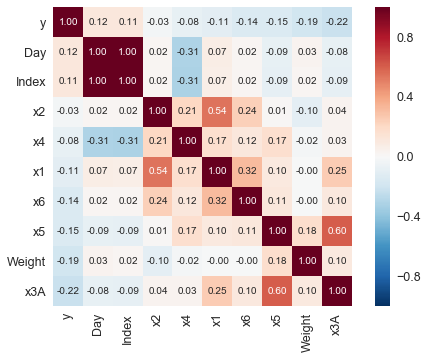

In [60]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'y')['y'].index
cm = np.corrcoef(df_stock_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


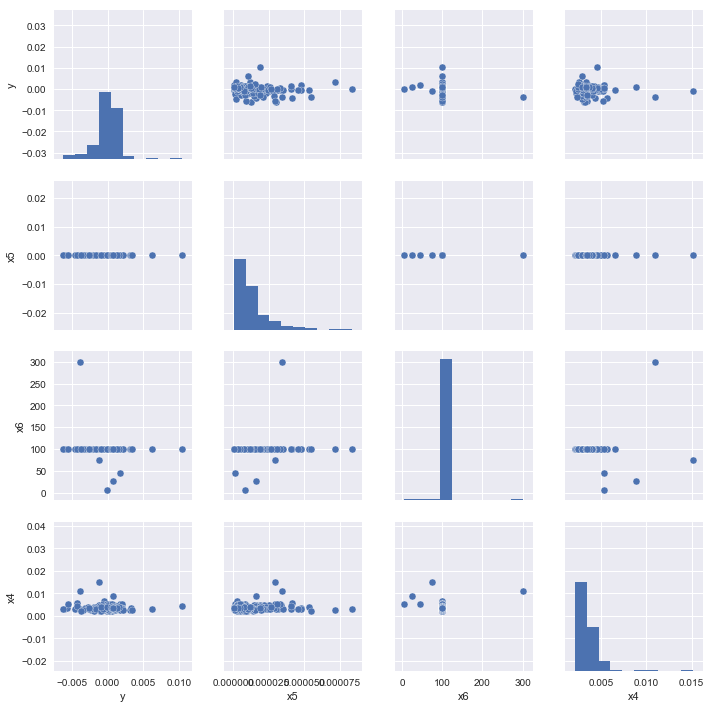

In [61]:
#How is y related to 'x5','x6','x4'.
#scatterplot
sns.set()
cols = ['y', 'x5','x6','x4']
sns.pairplot(df_stock_train[cols], size = 2.5)
plt.show();

In [76]:
df_stock_train = df_train.loc[ (df_train.Stock == 363)]
df_stock_train.tail()

,Index,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6,y,Weight
41237,41237,1,295,363,0.008958,0.581378,0.487078,0.000012,0.000035,0.000074,0.000174,0.000342,0.003057,0.000017,100.0,0.000485,0.671299
41610,41610,1,299,363,0.000894,0.647792,0.518616,0.000009,0.000025,0.000037,0.000049,0.000047,0.003066,0.000008,100.0,0.001539,0.634245
41983,41983,1,301,363,0.002597,0.738516,0.486739,0.000013,0.000039,0.000056,0.000053,0.000071,0.003105,0.000012,100.0,0.001305,0.747641
42356,42356,1,303,363,0.000745,0.505944,0.521626,0.000005,0.000022,0.000047,0.000055,0.000037,0.003106,0.000005,100.0,0.002870,0.599105
42729,42729,1,307,363,0.001109,0.787572,0.523690,0.000011,0.000026,0.000045,0.000049,0.000070,0.003130,0.000016,100.0,0.002498,0.673118


In [74]:
# Chart the BTC pricing data
df_stock_train = df_train.loc[ (df_train.Market == 1) & (df_train.Stock == 363)]
y_trace = go.Scatter(x=df_stock_train['Day'], y=df_stock_train['y'])
py.iplot([y_trace])

In [72]:
# Chart the BTC pricing data
df_stock_train = df_train.loc[ (df_train.Market == 1) & (df_train.Stock == 1223)]
y_trace = go.Scatter(x=df_stock_train['Day'], y=df_stock_train['y'])
py.iplot([y_trace])

In [14]:
# Chart the BTC pricing data
df_stock_train = df_train.loc[ (df_train.Market == 1) & (df_train.Stock == 1372)]
y_trace = go.Scatter(x=df_stock_train['Day'], y=df_stock_train['y'])
py.iplot([y_trace])

In [172]:
# Chart the BTC pricing data
df_stock_train = df_train.loc[ (df_train.Market == 4) & (df_train.Stock == 684)]
y_trace = go.Scatter(x=df_stock_train['Day'], y=df_stock_train['y'])
py.iplot([y_trace])

In [173]:
#df_gb = df_train.groupby('Market')('Stock')['y']
unique_count = len(df_train.groupby(['Market']['Stock'])['y'].count())

TypeError: list indices must be integers or slices, not str

In [160]:
df1 = df_train.groupby(['Market', 'Stock'])

#grouped = df.groupby(['A', 'B'])
#grouped.aggregate(np.sum)

In [167]:
df2 = df1.aggregate(np.sum)

In [168]:
df3 = pd.DataFrame(df2)

In [171]:
df3

Index    Day           x0          x1          x2       x3A  \
Market Stock                                                                    
1      10      11430540  86401    11.317595  136.781967   94.498729  0.000029   
       12      11431038  86401    12.338810  143.387268  108.479446  0.000027   
       15      11413894  86401     2.210415  149.669633   92.813018  0.001467   
       20      11424932  86401    11.396016  171.688482  126.746535  0.000064   
       22       5397096  39508    76.101590  111.657928  108.812065  0.002271   
       29      11428487  86401     2.375689  124.880485  101.807338  0.000258   
       32       2539555  17915     0.117694   52.724715   56.183405  0.000532   
       34       9871882  75250     0.635191  120.386935   85.168881  0.000376   
       42       9222698  68395     0.338502  139.618555   92.488576  0.001185   
       48      11439756  86401    41.289646  193.843544  148.438803  0.000107   
       60       3921008  30511     0.895786   39.328772   38.828682  0.000875   
       70      11395662  86401     5.255061  123.253213   80.357948  0.000072   
       71      11406262  86401     1.741610  137.030450  104.828341  0.000155   
       79        982302   6820     0.196294   39.752331   44.444030  0.000283   
       87      11421340  86401     7.941085  150.863194  111.460763  0.000204   
       90      11399708  86401     6.053609  115.120709   80.409540  0.000007   
       109     11420324  86401     5.688067  125.748944   95.189758  0.000015   
       123      7099797  55141     1.798164   50.414694   47.531426  0.000267   
       124     11438013  86401     3.531773  140.366016  111.543824  0.000233   
       127     11361792  85637     0.598486  138.389220  132.483458  0.000289   
       128     11447281  86401     1.791662  191.800444  114.286184  0.000128   
       134      5093561  36929    12.438058   83.683642   66.276387  0.000032   
       136      7141204  52224     0.015518  153.923498  105.865873  0.003880   
       138      8522697  62666     1.143802  128.077322  122.432477  0.000843   
       144     11445455  86401     7.919138  147.007879  114.291381  0.000572   
       147     11404944  86401     3.396705  135.489580  102.102397  0.000113   
       153     11437515  86401     5.058247  165.519515  120.999864  0.000548   
       155      1335409   9297     0.071971   68.717377   82.976870  0.000632   
       175     11461408  86401    20.627568  195.596540  144.214776  0.000079   
       181     11278462  85070     1.721153  100.328298   88.547854  0.000512   
...                 ...    ...          ...         ...         ...       ...   
4      2625    85046389  70701  7309.308144  105.637833  109.403160  0.000806   
       2632   148732632  85930     1.653441  712.092873  402.557822  0.000150   
       2645   154159700  88893     3.607450  614.088158  190.897703  0.000042   
       2695    33335064   4065     0.046963  129.459601   51.597607  0.000153   
       2707    31374398  29003     8.255023   50.662506   47.837850  0.000117   
       2710    35295195  36728     5.992431  146.584223  147.015332  0.001064   
       2716   140793716  88257    10.867184  393.399433  351.946733  0.000500   
       2722   153553518  88629   487.987782  261.945253  153.091751  0.000083   
       2727    45535739  42311     0.476147  130.311592   84.743970  0.000416   
       2733     8097244   9250     0.841434   58.422304   59.114730  0.000197   
       2741   134009892  72962    26.608687  313.672261  228.407781  0.000727   
       2791   154169921  88893    33.266677  356.194119  153.860211  0.000061   
       2841   153575913  88629     1.591019  423.176075  212.259546  0.000054   
       2842    43390520   6895     0.077561  150.398414  108.816183  0.000873   
       2849   153560922  88629    14.932053  455.864515  201.635847  0.000103   
       2862   154171647  88893     1.610633  386.375165  337.230579  0.001002   
       2863   153561177  88629    23.163499  413.